In [36]:
import CO2_Dataset_Preparation
import ML_Model_Master
import Result_Retriever

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *
from datetime import datetime
import pickle
import glob
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import importlib
importlib.reload(CO2_Dataset_Preparation)
importlib.reload(ML_Model_Master)
importlib.reload(Result_Retriever)

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *


In [29]:
#Data parameters - The below parameters can be set if access to original data is available
#If you are using the github repo, your options are limited to the saved ML data. Do not
#run this cell, and run the one below

tower = 'Picarro'
pn = 4
excess_rolls = [60,600,3600] #these specify the rolling window on which a minimum is applied for excess 
feature_columns = ['Pic_CO2','Pic_CH4','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 60
periods_to_lag = 2 #using series to supervised lagging function
train_percent = 0.7 #percentage of data to train on, holdout is sequential not random

#Get data
data = Processed_Set(tower,pn,excess_rolls,vent_bool =True,wbb_bool=False) #create data object
data._retrieve_data('../CO2_Data_Processed/') #get data from folder
data._apply_excess() #apply excess concentrations

#Make into ml_data
ml_data = ML_Data(downsample_sec,periods_to_lag,tower,train_percent,feature_columns = feature_columns) #create object
ml_data._ML_Process(data) #process into ml data

pkl_bool = bool(input("Save To Pickle File? Enter True or False")) #save to pickle if desired
if pkl_bool:
    file_name = f'ml_data_pn{pn}_ds{downsample_sec}.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(ml_data, file)   

Applying excess using minimum on windows: [60, 600, 3600]
Downsampling by mean at 60 seconds
Downsampling by mean at 60 seconds
Adding Wind Direction for ANEM_X,ANEM_Y as 'wd'
Adding Wind Speed for ANEM_X,ANEM_Y as 'ws'
Save To Pickle File? Enter True or FalseTrue


In [25]:
# Run this cell if you are in the git repo with no access to raw data
# Choose a file and load into ml_data
import sys
files = glob.glob("ml_data*")
for cnt, file in enumerate(files,1):
    sys.stdout.write("[%d] %s\n\r" % (cnt, file))
choice = int(input('Select file [1-%s]: ' % cnt))
print(f' loading {files[choice]}')
with open(files[choice], 'rb') as file:
    ml_data = pickle.load(file)

[1] ml_data_pn4_ds60.pkl
[2] ml_data_pn1_ds60.pkl
Select file [1-2]: 1
 loading ml_data_pn1_ds60.pkl


In [30]:
# Set ML Model Parameters
activation = 'relu'
neurons = 256
dropout_rate = 0.2
learn_rate = 0.001
decay = 1e-5
batch_size = 20
epochs = 10
error_metric = 'rmse'

In [32]:
#Build and train model
ml_model = ML_Model_Builder(activation,neurons,dropout_rate,learn_rate,decay,batch_size,epochs) #create model object
ml_model._train_model(ml_data) #train


Downsampling = 60
Lag Periods = 2        
activation=relu
neurons=256
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=20
epochs=10
Train on 8989 samples, validate on 3853 samples
Epoch 1/10
8989/8989 [==============================] - 9s 1ms/step - loss: 0.0471 - rmse: 0.1656 - val_loss: 0.0243 - val_rmse: 0.1112
Epoch 2/10
8989/8989 [==============================] - 7s 749us/step - loss: 0.0326 - rmse: 0.1218 - val_loss: 0.0260 - val_rmse: 0.1043
Epoch 3/10
8989/8989 [==============================] - 7s 782us/step - loss: 0.0318 - rmse: 0.1191 - val_loss: 0.0239 - val_rmse: 0.1096
Epoch 4/10
8989/8989 [==============================] - 7s 765us/step - loss: 0.0313 - rmse: 0.1178 - val_loss: 0.0249 - val_rmse: 0.1029
Epoch 5/10
8989/8989 [==============================] - 8s 908us/step - loss: 0.0313 - rmse: 0.1171 - val_loss: 0.0239 - val_rmse: 0.1013
Epoch 6/10
8989/8989 [==============================] - 7s 755us/step - loss: 0.0309 - rmse: 0.1164 - val_loss: 0.02

Fitting data from X_test


/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


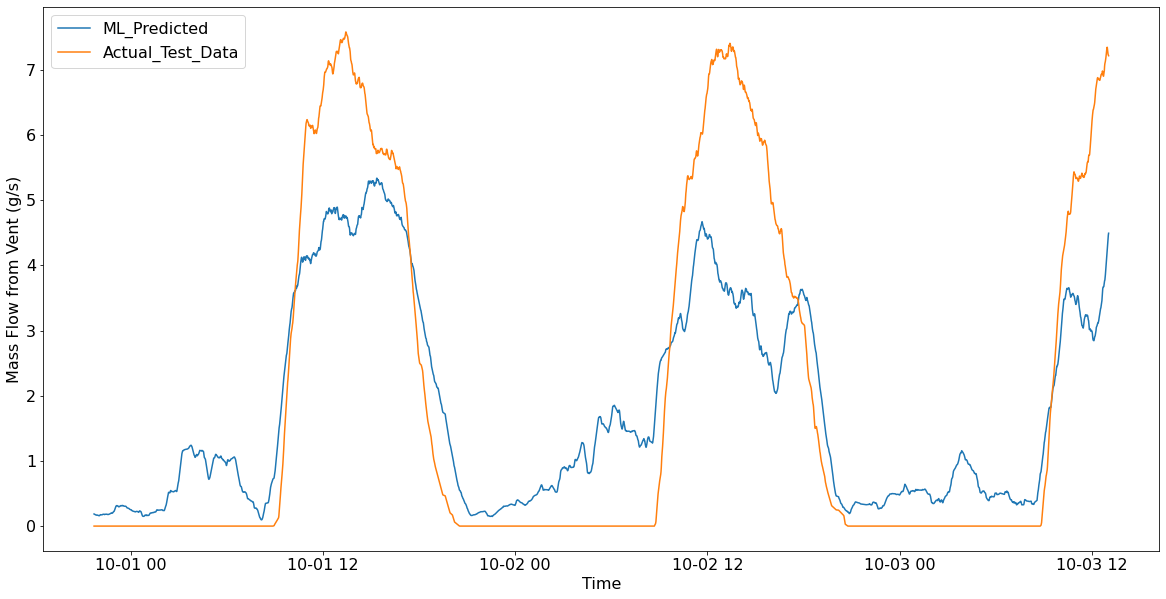

In [35]:
#Model fit and plot comparison

ml_model._fit_data(ml_data) #fit model

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

#Merge 
merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

# Get dt index from original data
df = ml_data.time_lagged_reframed.dropna().copy()
train = int(len(df)*train_percent)
df.reset_index(inplace = True)

dateidx = df.loc[train:,:].set_index('Corrected_DT').index
comparison.set_index(dateidx,inplace=True)

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))

roll = 100 #Number of rolling periods

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()

# ----------
# Results Retrieve
# ----------

-----Plotting Best Model Comparison-----


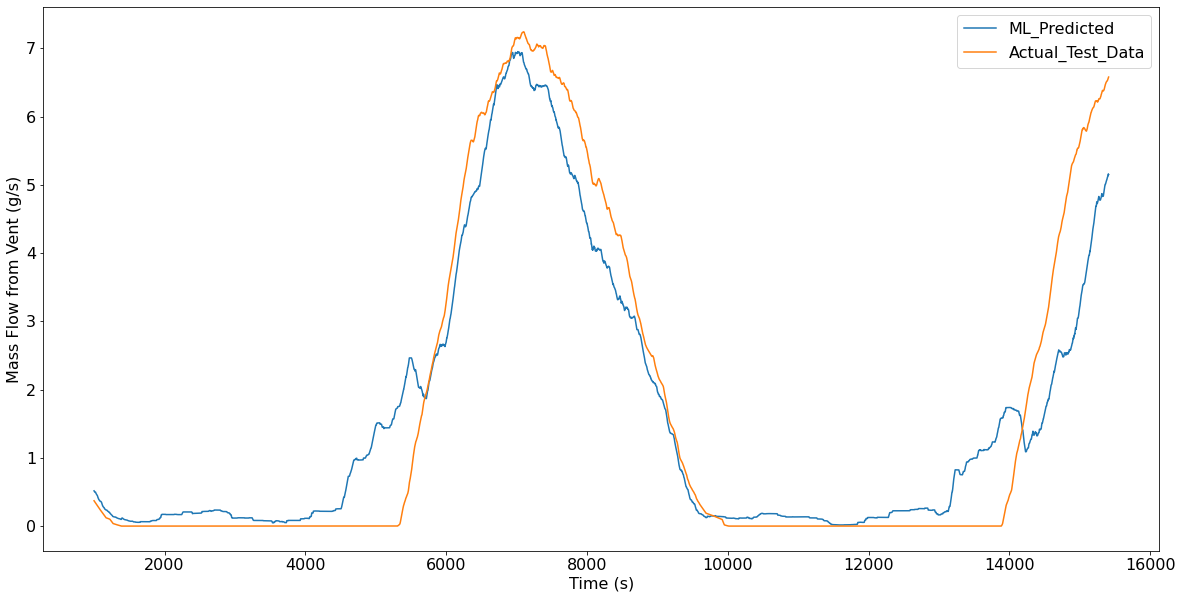

In [3]:
#This retrieves results from gridsearching. Need access to Gridsearch_Output folder
logfile = f'Gridsearch_Output/Picarro_CH4in_PN4_DS10_Lag6_Train0.8.out' #specify file
g = Gridsearch_Result_Retrieve(logfile) #create object
g._read_data_vars() #read the data variables
g._read_models() # read model outputs
g._find_best_model() #find the model with the lowest rmse
g._get_best_data('../CO2_Data_Processed/') #get the data for the best model from folder
g._retrain_fit_best() #retrain and fit the best model
g._plot_best_comparison(1000) #plot the test comparison. Argument is rolling average

In [3]:
#Get the errors for comparison
l = g.last_error
from operator import itemgetter
top_ten = sorted(enumerate(l),key=itemgetter(1))[0:10]
top_idx = [i[0]for i in top_ten]
top_models = []
for i in top_idx:
    top_models.append(g.models[i])
top_attr = {'neurons':[],'dropout_rate':[],'learn_rate':[],'decay':[],'batch_size':[],'epochs':[]}
for mod in top_models:
    top_attr['neurons'].append(mod.neurons)
    top_attr['dropout_rate'].append(mod.dropout_rate)
    top_attr['learn_rate'].append(mod.learn_rate)
    top_attr['decay'].append(mod.decay)
    top_attr['batch_size'].append(mod.batch_size)
    top_attr['epochs'].append(mod.epochs)